<a href="https://colab.research.google.com/github/nazmus007/transformers_test/blob/main/roberta_and_tpus_subramanian_run1_woutemojis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with RoBERTa

The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach by Yinhan Liu et al. It is based on Google’s BERT model released in 2018: it modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

See:
- RoBERTa's paper: https://arxiv.org/pdf/1907.11692.pdf
- BERT's paper: https://arxiv.org/pdf/1810.04805.pdf

In [1]:
!pip install -qq transformers

     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 75.8 MB/s 
     |████████████████████████████████| 596 kB 77.6 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 


In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter


In [3]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.21.158.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.21.158.218:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  grpc://10.21.158.218:8470
Number of replicas: 8


In [4]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 128
ARTIFACTS_PATH = './drive/MyDrive/artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 5

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [5]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
exit()

## Prepare dataset

Note that I have already cleaned the dataset, so the training should be better:
- Remove punctuation symbols and double white spaces.
- Lemmatization.
- Remove stop words (see `spacy.lang.en.stop_words.STOP_WORDS`).
- TD-IDF

The reason of this preprocess is that I have used this dataset with other models, such as LSTM. However, I believe (I didn't test it) that RoBERTa could deal with it.

In [6]:
df = pd.read_csv('/drive/MyDrive/datasets/cleaned_subramanian_wemojis_final.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Tweet,Label
0,0,0,that has / that is how we roll😎 . . . . . . . ...,1
1,2,2,at my brother barbara school . i am only one c...,1
2,3,3,and i don’t know why people get hurt 😄 stupid...,1
3,4,4,yay. i see a cold in my near future 😂 jokes fu...,1
4,5,5,1. alaa.. takpe kan ada cleaner 2. diorg pun b...,1


In [23]:
def removeUnicode(text):
     # Removes unicode strings like "\u002c" and "x96" 
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

In [24]:
df['Tweet'] = df['Tweet'].apply(removeUnicode)

In [ ]:
df.columns = df.columns.str.lstrip()

In [26]:
X_data = df[['Tweet']].to_numpy()
y_data = df[['Label']].to_numpy()

In [27]:
print(X_data[90:93])

[['ek bacchi thi nadan si har baat pe randi-rona kiya karti thi  dedicated  sarcastic']
 ['what news to wake up to. who knew i could spread this on my toast and my face. win win! ']
 ['simmba rohitshetty  is this some next level naagin dance?? performed by michael jackson.']]


In [9]:
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 788 kB/s 


In [10]:
import demoji
def demoji_text(text):
  d= demoji.findall(text)
  return d

In [11]:
df['emoji_list'] = df['Tweet'].apply(demoji_text)

In [12]:
f= list(filter(None, df['emoji_list']))

In [13]:
print(f)

[{'😎': 'smiling face with sunglasses'}, {'😂': 'face with tears of joy'}, {'😄': 'grinning face with smiling eyes'}, {'😂': 'face with tears of joy'}, {'😏': 'smirking face'}, {'😂': 'face with tears of joy'}, {'😉': 'winking face', '🤣': 'rolling on the floor laughing'}, {'🤣': 'rolling on the floor laughing', '😂': 'face with tears of joy'}, {'🤣': 'rolling on the floor laughing', '😂': 'face with tears of joy'}, {'😂': 'face with tears of joy'}, {'👏': 'clapping hands'}, {'😁': 'beaming face with smiling eyes'}, {'😒': 'unamused face'}, {'😂': 'face with tears of joy'}, {'💞': 'revolving hearts'}, {'🎪': 'circus tent'}, {'😉': 'winking face'}, {'🔥': 'fire'}, {'😏': 'smirking face'}, {'😜': 'winking face with tongue'}, {'😂': 'face with tears of joy'}, {'😮': 'face with open mouth', '🙌🏽': 'raising hands: medium skin tone'}, {'❓': 'red question mark', '🙄': 'face with rolling eyes', '🥃': 'tumbler glass'}, {'😅': 'grinning face with sweat'}, {'😀': 'grinning face'}, {'👍': 'thumbs up', '🤬': 'face with symbols on

In [14]:
all_keys = set().union(*(d.keys() for d in f))

In [15]:
print(all_keys)

{'🎫', '🍧', '👏🏽', '🎵', '👮\u200d♀️', '♥', '🙋🏻\u200d♀️', '✔️', '🤙🏻', '🤷🏻\u200d♂️', '❕', '📃', '🔰', '👫', '🍸', '🔞', '🏢', '🔗', '😞', '🇫🇷', '☹️', '🙍', '👵🏾', '👅', '🇦🇷', '⤵', '🕵️', '🌮', '😯', '🦖', '📶', '❣️', '🤷🏻\u200d♀️', '👎🏻', '☯️', '🤔', '🤷🏾', '🇷🇺', '🙏🏾', '🤷', '🦇', '👧🏽', '🐒', '💕', '♠️', '🐕', '🐱', '👆', '🙅🏻\u200d♂️', '📱', '🌾', '👇🏼', '🍦', '🍗', '🙋', '😮', '💇🏾\u200d♀️', '🧘🏽\u200d♀️', '💪🏽', '⛹🏽\u200d♂️', '🐸', '👶🏽', '🤹🏻\u200d♀️', '💡', '💎', '😚', '🤚🏽', '🗣', '💞', '💟', '🍽', '🐠', '💖', '🐫', '🐷', '🔋', '👍', '🎿', '🍫', '😗', '🎨', '📹', '😇', '🍴', '🐟', '👼🏻', '🐋', '🐘', '🎈', '🎖️', '🗡️', '🇪🇸', '🤤', '📍', '🤘', '💳', '💁', '☝️', '👆🏽', '👊', '3️⃣', '😐', '🛩️', '🐽', '❄', '🍤', '💃🏽', '🐇', '✏️', '🌵', '🤝', '🏴\U000e0067\U000e0062\U000e0065\U000e006e\U000e0067\U000e007f', '👆🏼', '🍟', '🦂', '🏗', '💆🏻\u200d♂', '🤗', '🧘🏻\u200d♀️', '🏀', '🙌🏿', '🐑', '🌟', '🐭', '🧔🏿', '😋', '🔉', '💸', '🤮', '💔', '🤶🏻', '⚽', '⬆', '🔥', '💿', '😆', '☠️', '🕺', '🍏', '👨🏻\u200d💻', '🍿', '👚', '💊', '🎣', '🥵', '🙏🏼', '🌅', '➡', '🗿', '🎮', '🌸', '🐻', '👋', '🤫', '👏🏿', '🐣', '😠', '🙌🏼', '🏖', 

In [16]:
len(all_keys)

780

In [28]:
X_data = X_data.reshape(-1)
y_data = y_data.reshape(-1)

In [29]:
print(X_data[:10])

['that has / that is how we roll . . . . . . . . cinemaddicts9 talkohlics scienceofstupid nationalgeographic crew team celebration production filmakers filmmaking cinema instagram memes meme  sarcastic funny funnyquotes boomerang fun crazy'
 'at my brother barbara school . i am only one can in  thebid  . . .  . .   hilarious mentor teacher standupcomedy funnymemes vines like  funnymeme cute oh my god xd  https'
 'and i dont know why people get hurt   stupidity laugh out loud laughteristhebestmedicine humor funny bellylaugh funnymoments shirtisfy comedy meme funnyphoto gigglesgalore funnyvideo hilarious  jokes haha epic allforfun funnymoments ithoughtiwascool'
 'yay. i see a cold in my near future  jokes funny  austin atx forecast atxwx weather weatherfortheweekahead https'
 '1. alaa.. takpe kan ada cleaner 2. diorg pun buang sampah jugak     https'
 'you said bye-bye? . aww'
 'bali is amazing.   yes do not buy it ever... . '
 'i bet the wall would prevent this... . . trump cocainecowbo

# Dataset analysis

As you can see in the following plot, the samples **are not balanced**. This could cause problems during the training but, since they are not highly unbalanced, I have left it as it is.

In other cases, such as fraud detecting where the positive classes are very few compared to the negative ones, we must apply techniques to balance it. For example, we could undersample the biggest category.

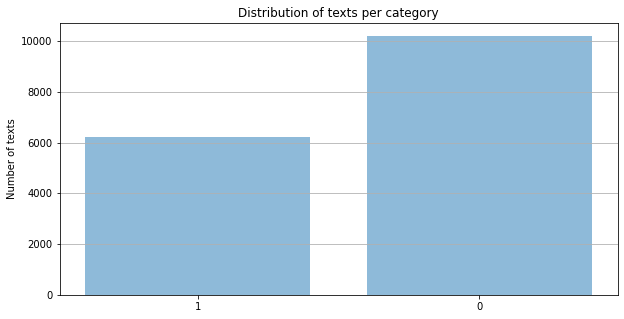

Counter({0: 10198, 1: 6198})


In [18]:
categories = df[['Label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [19]:
def calculate_stats(df, split_char=' '):
    categories = df['Label'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['Tweet']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['Label']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['Label'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In these histograms and stats, we can see that almost all texts contain $500$ or less words. Also, we can see that the average length is very different depending on the category.

Please, note that the tokenization process may split words into several parts, so lengths could increase (or decrease too). This is only an orientative result.

In [20]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
1,"[36, 34, 31, 19, 14, 5, 11, 18, 38, 12, 7, 24,...",17.829784,10.268616
0,"[3, 22, 6, 3, 5, 5, 4, 5, 10, 10, 10, 12, 6, 6...",12.486174,9.595351


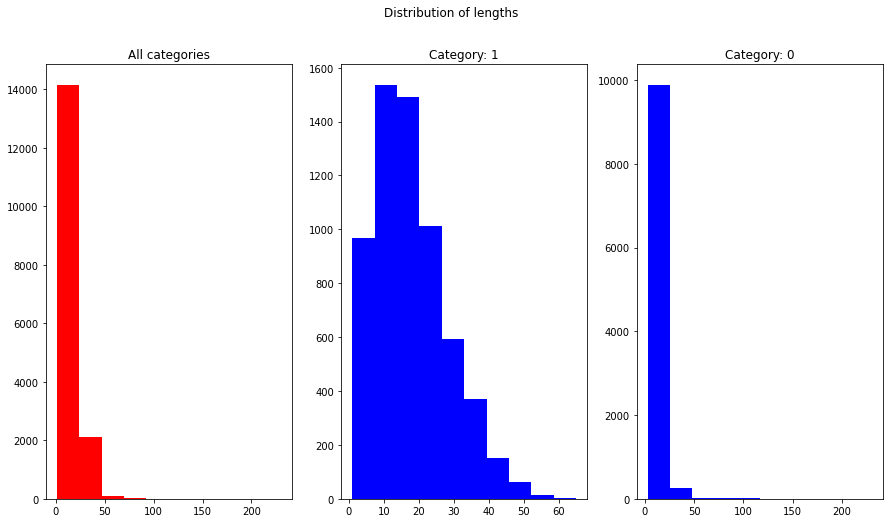

In [21]:
display_lengths_histograms(df_stats)

In [30]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['Label'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 16396
Number of categories: 2
Done!


# Tokenize & encode

I am going to import the RoBERTa model from HuggingFace. Note that I must import not only the model but also the tokenizer (since I must use the same vocabulary as the model was trained with).

We should take into account that RoBERTa's input accepts up-to 512 tokens, thus **we must truncate the tokenized texts**. In my case, I truncate to 256 tokens, but you can put a higher value in the variable `MAX_LEN`.

See https://huggingface.co/roberta-base

In [31]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        #tok_text= tokenizer.add_tokens(['😀', '😏', '☺️', '🎾', '🍧', '💔', '📯', '😿', '😶', '🍔', '🇬🇧', '📖', '😊', '🌏', '🎸', '😥', '🍝', '🎌', '✋', '😳', '💅', '👆', '🔮', '🍬', '👈', '😍', '😕', '🚬', '🔥', '☃', '🔞', '👔', '🏊', '💝', '🐒', '🎈', '🌴', '🏃', '🍩', '👎', '🍤', '💩', '©', '🚴', '🐣', '👻', '🚼', '💊', '🌱', '🙆', '🙅', '👅', '🐤', '❗', '✖', '💰', '⚡', '💂', '⬅️', '💚', '💌', '🍕', '🎁', '👊', '😱', '🌌', '📚', '💞', '🍭', '⛄', '👳', '🎤', '📀', '💨', '😁', '😨', '💖', '🚗', '😇', '💧', '🇫🇷', '😎', '🌃', '〰', '💽', '🏂', '🆒', '🍦', '😩', '🌻', '💀', '⏰', '🍲', '🚢', '😅', '🍅', '😣', '👱', '😈', '🎆', '🍳', '🎎', '🍗', '💙', '🙊', '☹', '🍸', '💐', '🌅', '🎮', '🐬', '😯', '👃', '🍷', '🍖', '😒', '🍊', '🌸', '🍻', '🐽', '😰', '🆘', '🐛', '🍃', '😠', '🍰', '🎿', '🙌', '😪', '☠', '☀️', '▶', '👀', '🍺', '😢', '👫', '🙈', '🚔', '🎊', '😑', '🎹', '◽', '☮', '✊', '👩', '🚨', '💕', '⭐', '❌', '👬', '😭', '🌲', '🌀', '🍹', '💆', '👌', '▪', '💎', '➡️', '😓', '☺', '🍓', '💋', '🐾', '🍛', '👠', '🌆', '™', '📓', '🙀', '🚀', '🙋', '💢', '🎼', '🍍', '✴', '😽', '😝', '👶', '😫', '😐', '❄', '💻', '👙', '✔️', '😵', '😬', '😮', '🍉', '👾', '🏄', '😚', '🎨', '💛', '😜', '🐥', '🔄', '🌠', '❄️', '👋', '😦', '🔆', '💯', '🌞', '😌', '💁', '🎉', '📺', '♦', '🕑', '🌎', '🎶', '👏', '😃', '🐇', '🍏', '🇩🇪', '☕', '😴', '🎵', '🌍', '🙉', '👂', '😷', '🐶', '🕥', '👯', '🌙', '🕐', '😙', '🎀', '💸', '😆', '🔫', '♏', '😉', '👭', '🐷', '💘', '👿', '♥', '☁️', '🎓', '😂', '⁉️', '😟', '💟', '💜', '😤', '🌊', '🌾', '🐴', '🍨', '🏡', '🐰', '😲', '💳', '🚶', '🍁', '😡', '🐳', '🔪', '🍠', '🌁', '😻', '🔯', '🔅', '🍀', '🎻', '🍵', '🐠', '👉', '☀', '👪', '✌', '👜', '💥', '😹', '👣', '🍈', '🇺🇸', '📨', '🇮🇹', '😗', '🌚', '💵', '🙍', '🎄', '🐉', '◾', '🌂', '💍', '⛪', '🎧', '❤️', '®', '❤', '👑', '💣', '🍋', '🎺', '📑', '🚺', '😘', '✌️', '🚫', '🌽', '💤', '🎥', '✏', '💪', '🏰', '😞', '✖️', '👹', '📣', '😺', '😄', '👰', '☔', '🎅', '😔', '☂', '💼', '🚓', '🍫', '👄', '💄', '👐', '💗', '🌵', '🐟', '💃', '🙏', '✨', '☝️', '☁', '🏈', '🍪', '⛅', '💉', '🐭', '⚽', '😛', '🍟', '💏', '😋', '📄', '🏥', '🐼', '♥️', '😧', '💦', '🎷', '🎂', '📱', '🚙', '👼', '🍆', '✈', '👸', '🎭', '🐸', '👍', '✈️', '😖', '🎋', '🐧'])
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [32]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 1, 1: 0}

In [33]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [34]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [35]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

## Create RoBERTa model

In [38]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        roberta_model.resize_token_embeddings(len(tokenizer))
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=2e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [39]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_mask[0][0]',       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Train model

This is basic training of RoBERTa but, if your dataset is larger, you may use K-Folds in this section. In this notebook, I use K-Folds (use it as inspiration): https://www.kaggle.com/dimasmunoz/clean-english-data-roberta ;)

In [40]:
with strategy.scope():
    print('Starting training.....')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Starting training.....
Epoch 1/5


180/180 [==============================] - 167s 477ms/step - loss: 0.2237 - accuracy: 0.9130 - val_loss: 0.1418 - val_accuracy: 0.9488
Epoch 2/5
180/180 [==============================] - 22s 120ms/step - loss: 0.1260 - accuracy: 0.9553 - val_loss: 0.1376 - val_accuracy: 0.9502
Epoch 3/5
180/180 [==============================] - 21s 119ms/step - loss: 0.0887 - accuracy: 0.9665 - val_loss: 0.1421 - val_accuracy: 0.9520
Epoch 4/5
180/180 [==============================] - 21s 119ms/step - loss: 0.0579 - accuracy: 0.9788 - val_loss: 0.1683 - val_accuracy: 0.9500
Epoch 5/5
180/180 [==============================] - 21s 119ms/step - loss: 0.0277 - accuracy: 0.9894 - val_loss: 0.2441 - val_accuracy: 0.9354


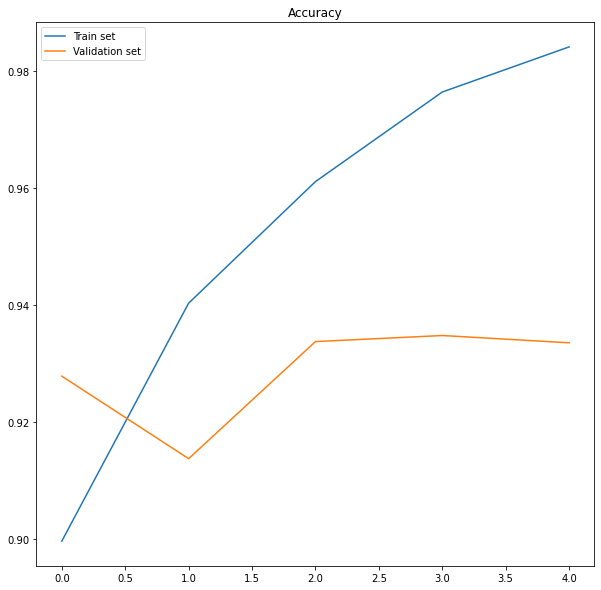

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

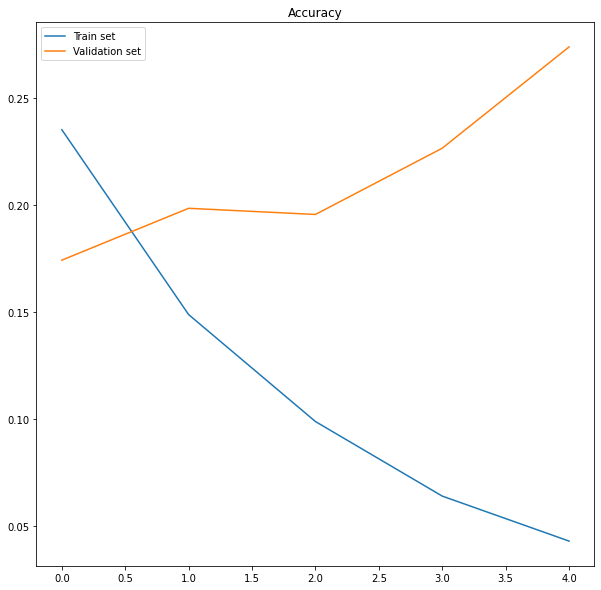

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['loss']))
plt.plot(xaxis, history.history['loss'], label='Train set')
plt.plot(xaxis, history.history['val_loss'], label='Validation set')
plt.legend()

## Evaluation

In a confusion matrix, we can see how many categories are classified c

In [41]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 93.54%


In [43]:
class_names=['1', '0']

In [44]:
y_pred= model.predict(X_test)
y_pred = [np.argmax(i) for i in model.predict(X_test)]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           1       0.89      0.94      0.91      1816
           0       0.96      0.94      0.95      3103

    accuracy                           0.94      4919
   macro avg       0.93      0.94      0.93      4919
weighted avg       0.94      0.94      0.94      4919



In [45]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Lablel')
  plt.xlabel('Predicted label');

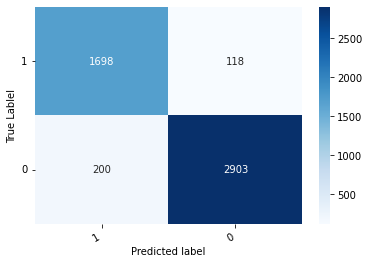

In [46]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

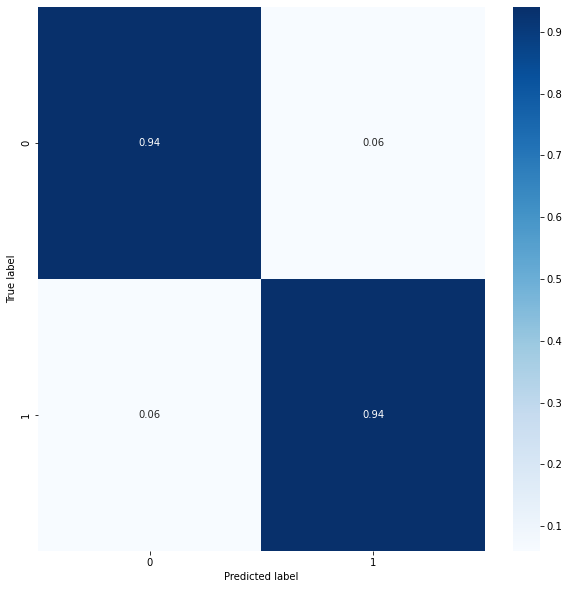

In [47]:
plot_confusion_matrix(X_test, y_test, model)